# PP-Index
This notebook contains our implementation of the PP-Index.

## Import libraries
First of all, we import all the libraries we will need.

In [ ]:
import numpy as np
import time
import os
import pickle
import sklearn 
import sklearn.metrics
from operator import xor
from scipy.sparse.construct import random
import concurrent.futures

## The Prefix Tree
The prefix tree is the data structure on which the PP-index is based. It is built on all the permutation prefixes generated for the indexed objects and is kept in main memory. Given a set of objects $𝐷$ to be indexed we need:


*   a *similarity measure* $𝑑$
*   a set of *pivots* $𝑃$
*   a *permutation prefix length* $𝑙$

Then, any object ${o_i}∈𝐷$ is represented by a permutation prefix $𝑤_{o_i}$  consisting of the first $𝑙$ elements of the permutation $\Pi_{o_i}$. 

The permutation $\Pi_{o_i}$consists of the list of identifiers of pivots, sorted by their distance with respect to the object.

A node within the tree can be either the root, an internal node, or a leaf. Either way, we store the following information for each node:

*   `id`: pivot identifier corresponding to the current node within the prefix. It uniquely identifies the node within a path. For the root it is an empty string
*   `numeric path`: permutation prefix truncated at the current node. It uniquely identifies the node within the tree. For the root it is an empty string
*   `referenced objects`: number of objects referenced by the leaves that can be reached from the current node
*   `children`: list of children of the node. If the node is the root or an internal node, it is a list of nodes. In the case where the node is a leaf, it is a list of database object identifiers



In [ ]:
class Node:
  def __init__(self, id = '', numeric_path = '', referenced_objects = 0, children = []):
    self.id = id
    self.numeric_path = numeric_path
    self.referenced_objects = referenced_objects
    self.children = children

Based on the Node structure, in the following we define the whole Prefix Tree.

The PP-Tree will contain the information about the permutations of every object: each node represents a certain index in the permutation (the current level of the three specifies the position of the index in the permutation), the leaves store everything is needed to identify the objects with that prefix and to compute the distances w.r.t to the query.

A graphical representation of our PP-Tree implementation is reported in the figure below:

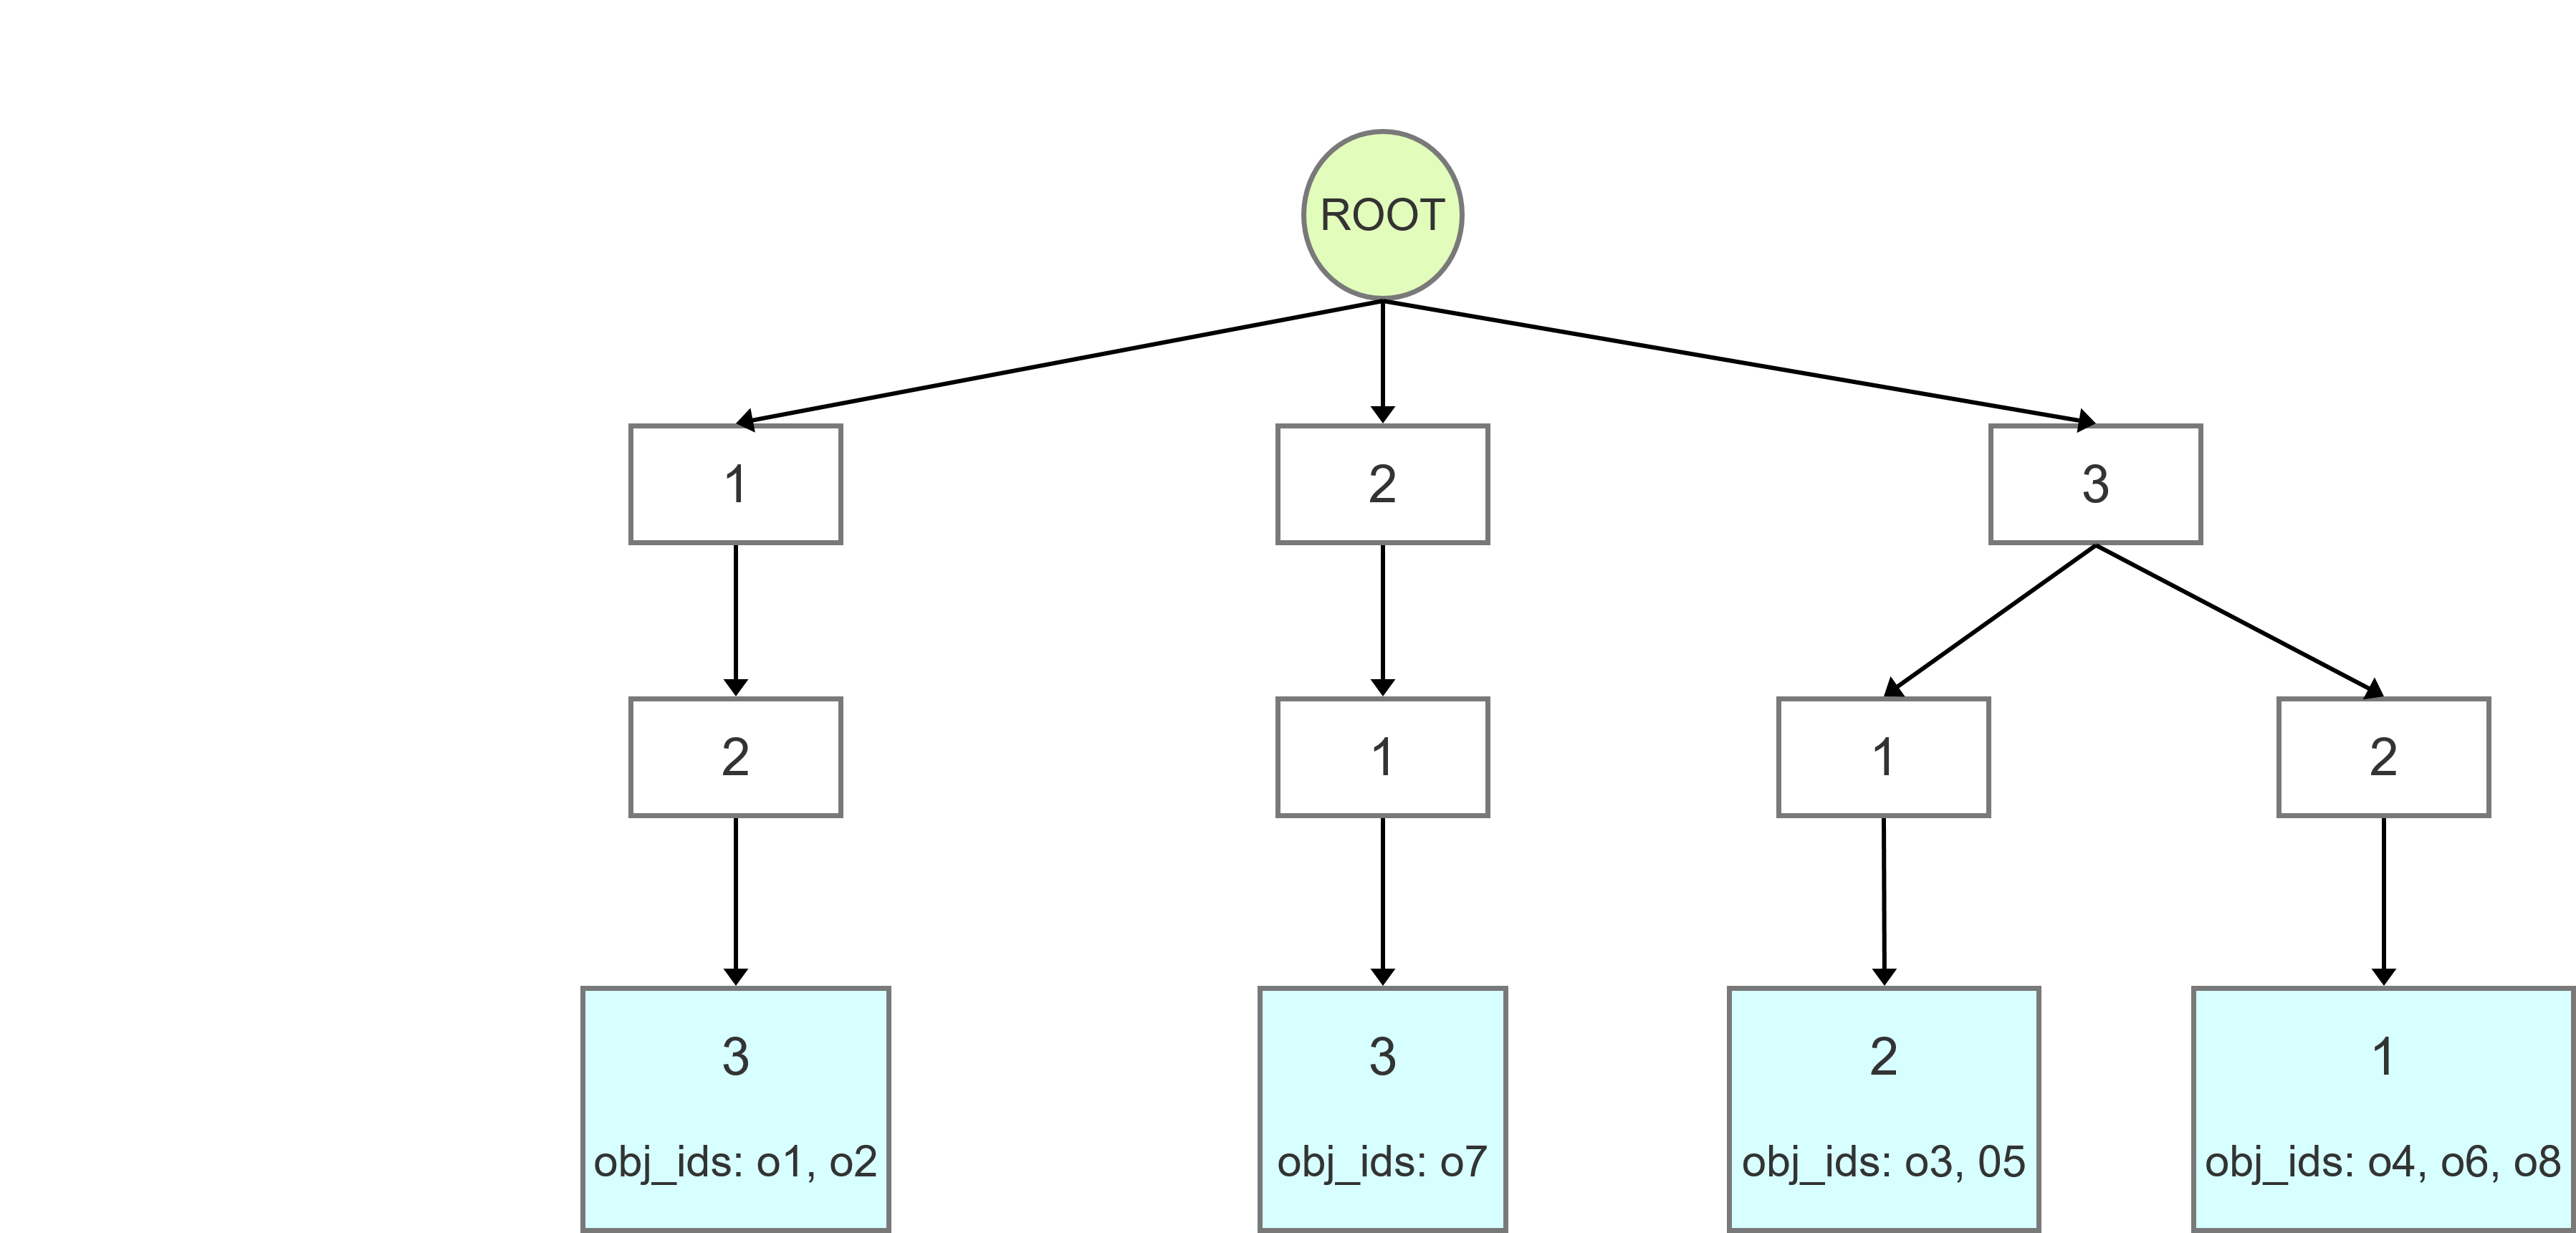

From this picture we can see that:


*   The root (green circle), is an empty Node, that only acts as entrypoint for the tree building and traversal. Its Id is empty, its level is 0
*   Intermediate nodes (white square) store a Node Id, which represent the $i^{th}$ value of the prefix of all the objects in their subtree, where $i$ is the level at which the node is. For example, the first node on the right has ID=3 and it is placed at level 1; it means that all the objects in the subtree (o3, o5, o4, o6, o8) have 3 as first value of their prefix  

*   Leaf nodes (light blue square) are nodes that not only store their id, but also the ids of the object whose prefix is the concatenation of the IDs of all the nodes from the root to that leaf


## Implementation choices

Differently from the original PP-Index implemetation, we decide to apply 2 main differences:

### Tree structure

The original Prefix Tree consists of a root that directly stores all the first level prefix values. Each of them also has a pointer to its children, which in turn is an array of second level prefix values and so on. The leaf stores 3 important fields, namely the $Referenced Objects$ list and 2 $h_{start}$ and $h_{end}$ pointers to the zone in the disk where we are storing the descriptors of the objects with that prefix.

In our implementation, in order to create a simpler architecture we decide to:

*   Standardize every node to a Node element, regardless of its position in the Tree
*   Allocate 1 node for each prefix number, and not multiple numbers in the same node, to allow a better management of the children
*   Compliantly with Python, we do not use pointers to children but only references
*   Leaves store only the $ReferencedObjects$ list, and has no need to use $h_{start}$ and $h_{end}$, indeed the prefix is enough to reference the file in which object descriptors are stored
*   Every Node has a counter of referenced objects in the subtree, it is exploited at query time: whenever the algorithm has to choose a node whose prefix is different from the query one, **it will choose the node that references the minimum number of objects**

### Disk storage

In the original paper, a single file is used, storing objects with the same prefix in contiguous portions of the disk.

We opted for a slightly different technique: we initialized one file for each permutation to store every object with that prefix in the file (e.g. object with prefix "123" store their descriptors in "123.npy"). In this way we have that:

*   We are **not required to keep pointers in the leaves**, just the permutation is enough to find where to seek on the disk 
*   Tree building is for sure **faster**, since we don't need to seek the position where to write in the file, but we apply a simple append. Writing many times in the middle of a file could cause many disk relocation, slowing down considerably the I/O operation 
*   From the point of view of code simplicity, this approach is much more readable and less error-prone, and allows for a better organization of data
*   If objects with the same prefix of the query are enough ($≥k'$), K-NN candidates retrieval is **faster** because again we don't need to seek the file position and read from a very big file, but just read the whole content of a medium-sized file
*   If objects with the same prefix of the query are not enough ($< k'$), K-NN candidates retrieval is **slower** because this time we will have to access multiple files instead of reading from contiguous portions of the disk




## The Prefix Tree class

In [ ]:
class PrefixTree:
  def __init__(self, pivot, length = 5, distance_metric = 'euclidean', base_directory='/content', tree_file = 'tree_structure'): ## metti nome vero
    self.root = Node(referenced_objects=0, children=[])
    self.pivot = pivot 
    self.length = length
    self.distance_metric = distance_metric
    self.disk_path = base_directory
    if not os.path.exists(self.disk_path):
      os.makedirs(self.disk_path)
    self.tree_file = tree_file
    
    self.tree_file_path = os.path.join(self.disk_path, self.tree_file)
    if os.path.exists(self.tree_file_path):
      print("Tree retrieved from disk")
      self.root = self.load_tree(self.tree_file_path)
    else:
      print("[WARNING]: Tree is still empty")

  ### MATH UTILS FUNCTIONS ###  

  def compute_distance(self, o1, o2):
    if self.distance_metric == 'cosine':
      similarity = sklearn.metrics.pairwise.cosine_similarity(X=o1, Y=o2)
      return np.subtract(np.ones(similarity.shape), similarity)
    return sklearn.metrics.pairwise_distances(X=o1, Y=o2, metric=self.distance_metric)

  def descriptor_to_pp(self, object_descriptor, list_of_pivot_descriptors):
    distances = self.compute_distance(object_descriptor, list_of_pivot_descriptors).flatten()
    prefix = np.argsort(distances)[:self.length]
    return prefix

  ### I/O UTILITIES ###

  def tree_to_dict(self, node):
    children = node.children
    id = node.id
    numeric_path = node.numeric_path
    referenced_objects = node.referenced_objects

    if not isinstance(node.children[0], Node):      #leaf
      return {'id':id, 'numeric_path':numeric_path, 'object_referenced':referenced_objects, 'objects':children}
    else:
      child_dicts=[]
      for child in children:
        child_dicts.append(self.tree_to_dict(child))
      return {'id':id, 'numeric_path':numeric_path, 'object_referenced':referenced_objects, 'children':child_dicts}

  def dict_to_tree(self, dictionary):
    if 'objects' in dictionary.keys():      #we are in a leaf
      id = dictionary['id']
      numeric_path = dictionary['numeric_path']
      referenced_objects = dictionary['object_referenced']
      object_ids = dictionary['objects']
      n = Node(id, numeric_path, referenced_objects, children=object_ids)
      return n

    #we are in a node, children is list of dicts
    children = dictionary['children']       #it is a list
    children_nodes = []   #it will contain nodes
    for child_dict in children:
      children_nodes.append(self.dict_to_tree(child_dict))
    id = dictionary['id']
    numeric_path = dictionary['numeric_path']
    referenced_objects = dictionary['object_referenced']
    n = Node(id, numeric_path, referenced_objects, children=children_nodes)
    return n

  def retrieve_descriptors_from_disk(self, pp_candidates):
    descriptors = []
    for pp in pp_candidates:
      path = os.path.join(self.disk_path, self.tree_file + pp + '.npy') ## rivedi
      with open(path, 'rb') as f:
        try:
          while True:
            descriptors.append(np.load(f, allow_pickle=True))
        except:
          pass 
    return descriptors

  def load_tree_from_dict(self, dictionary):
    self.pivot = dictionary['pivots']
    self.length = dictionary['lenght']
    self.distance_metric = dictionary['distance']
    self.root = self.dict_to_tree(dictionary)
    return self

  def store_tree_to_dict(self):
    dictionary = self.tree_to_dict(self.root)
    dictionary['pivots'] = self.pivot
    dictionary['lenght'] = self.length
    dictionary['distance'] = self.distance_metric
    return dictionary

  def load_tree(self, file_path):
    with open(file_path, 'rb') as f:
        dictionary = pickle.load(f)
    self.pivot = dictionary['pivots']
    self.length = dictionary['lenght']
    self.distance_metric = dictionary['distance']
    return self.dict_to_tree(dictionary)

  def store_tree(self, file_path):
    dictionary = self.tree_to_dict(self.root)
    dictionary['pivots'] = self.pivot
    dictionary['lenght'] = self.length
    dictionary['distance'] = self.distance_metric
    with open(file_path, 'wb') as f:
        pickle.dump(dictionary, f)
  
  def save(self):
    self.store_tree(self.tree_file_path)

  ### TREE MANAGEMENT FUNCTIONS ###

  def insert(self, id_object, object_descriptor, prefix, node, i=0):
    node.referenced_objects +=1
    if i>len(prefix)-1:       #we reached a leaf
      with open(os.path.join(self.disk_path, self.tree_file  + node.numeric_path + '.npy'), 'ab') as f:
        np.save(f, object_descriptor)
      node.children.append(id_object)
      return
    
    id_child = prefix[i]
    if id_child not in [child.id for child in node.children]:       #if child does not already exist
      child_numeric_path = node.numeric_path + "_" + str(id_child)
      child = Node(id_child, child_numeric_path, children=[])
      node.children.append(child)
      # node.children.sort(key=lambda x: x.referenced_objects, reverse=False)
    else:
      child = [child for child in node.children if child.id == id_child][0]      #retrieve child whose id is the next number in the prefix 
    self.insert(id_object, object_descriptor, prefix, child, i+1)

  def search(self, query_prefix, k_prime, node, i=0):
    candidates = []
    if i>len(query_prefix)-1:
      candidates = [(node.numeric_path, node.children)]
      return candidates
    
    id_child = query_prefix[i]
    child = [child for child in node.children if child.id == id_child]
    if child:
      child = child[0]
      candidates = candidates + self.search(query_prefix, k_prime, child, i+1)
      if sum([len(candidate[1]) for candidate in candidates]) >= k_prime:
        return candidates
        
    old_child = child
    # for child in node.children:     
    for child in sorted(node.children, key=lambda x: x.referenced_objects, reverse=False):
      if child == old_child:
        continue
      candidates = candidates + self.search(query_prefix, k_prime, child, i+1)
      if sum([len(candidate[1]) for candidate in candidates]) >= k_prime:  
        return candidates
    return candidates 

  ### TREE USAGE FUNCTIONS ###

  def is_empty(self):
    return not self.root.children

  def insert_objects_into_tree(self, object_id_list):
    print("Inserting objects into", self.tree_file, "...")
    start_time = time.time()
    for object_id in object_id_list:
      object_descriptor=get_descriptor_from_id(object_id)
      permutation = self.descriptor_to_pp(object_descriptor.reshape(1,-1), self.pivot)
      self.insert(object_id, object_descriptor, permutation, self.root)
    print("--- Insertion into tree", self.tree_file, "completed: %.3f seconds ---" % (time.time() - start_time))

  def find_nearest_neighbors_using_prefix(self, query_descriptor, query_prefix, k, extended=False):
    k_prime = 5*k ## da rivedere
    candidates = self.search(query_prefix, k_prime, self.root, 0)
    pp_candidates = [candidate[0] for candidate in candidates]
    id_candidates = [candidate[1] for candidate in candidates]
    id_candidates = np.array([item for sublist in id_candidates for item in sublist]) # flatten
    candidates_descriptors = self.retrieve_descriptors_from_disk(pp_candidates)
    distances = self.compute_distance(query_descriptor.reshape(1,-1), candidates_descriptors).flatten()
    if extended:
      return (id_candidates, distances)
    idxs = np.argsort(distances)
    topk = idxs[:k]
    nearest_neighbors = id_candidates[topk]
    return nearest_neighbors, distances[topk]
  
  def find_nearest_neighbors(self, query_descriptor, k, extended = False):
    query_prefix = self.descriptor_to_pp(query_descriptor.reshape(1,-1), self.pivot)
    return self.find_nearest_neighbors_using_prefix(query_descriptor, query_prefix, k, extended)

  def find_nearest_neighbors_with_query_perturbation(self, query_descriptor, k, perturbations=3, extended=False):
    query_prefix = self.descriptor_to_pp(query_descriptor.reshape(1,-1), self.pivot)
    if len(query_prefix>1):
      swapped_prefixes = [query_prefix.tolist()]
      for i in range(perturbations):
        index_to_swap = np.random.choice(len(query_prefix)-2)
        new_prefix = query_prefix.tolist()
        new_prefix[index_to_swap], new_prefix[index_to_swap+1] = new_prefix[index_to_swap+1], new_prefix[index_to_swap]
        swapped_prefixes.append(new_prefix)

    swapped_prefixes = list(set(tuple(i) for i in swapped_prefixes))  # removes duplicates

    with concurrent.futures.ThreadPoolExecutor() as executor:
      candidates = [executor.submit(self.find_nearest_neighbors_using_prefix, query_descriptor, np.array(query_prefix), k, True) for query_prefix in swapped_prefixes]
      
      ids = []
      distances = []
      for candidate in concurrent.futures.as_completed(candidates):
        result = candidate.result()
        ids = ids + result[0].tolist()
        distances = distances + result[1].tolist()

      executor.shutdown(wait=True)

      distances = np.array(distances)
      ids = np.array(ids)
      if extended:
        return (ids, distances)
    
    idxs = np.argsort(distances)
    topk = idxs[:k*perturbations]
    nearest_neighbors = ids[topk]
    unique_indexes = np.sort(np.unique(nearest_neighbors, return_index=True)[1])[:k]
    return nearest_neighbors[unique_indexes], (distances[topk])[unique_indexes]

## Prefix "Forest"
One strategy for boosting the performance of PP-Index is to build a "forest" of prefix trees. 

In particular, $t$ different indexes are built, based on different $P_1, P_2, ..., P_t$ sets of pivots. This is based on the intuition that different pivots  sets produce many differently shaped partitions of the similarity space, resulting in a more complete coverage of the area around queries.



In [ ]:
class PrefixForest:
  def __init__(self, pivots, length = 5, distance_metric = 'euclidean', base_directory='/content', forest_file = 'forest_structure'):
    self.pivots = pivots 
    self.length = length
    self.distance_metric = distance_metric
    self.disk_path = base_directory
    self.forest = []

    if not os.path.exists(self.disk_path):
      os.makedirs(self.disk_path)

    self.forest_file = forest_file
    self.forest_file_path = os.path.join(self.disk_path, self.forest_file)
    if os.path.exists(self.forest_file_path):
      print("Forest retrieved from disk")
      self.forest = self.load_forest(self.forest_file_path)
    else:
      i = 0
      for pivot in pivots:
        i = i+1
        new_tree = PrefixTree(pivot, self.length, self.distance_metric, self.disk_path, tree_file="tree" + str(i)) #rivedi ultimo parametro
        self.forest.append(new_tree)
      print("[WARNING]: Forest is still empty")
  
  ### I/O UTILITIES ###
  def forest_to_dict(self, forest):
    trees_dict = []
    for tree in forest:
      trees_dict.append(tree.store_tree_to_dict())
    return {'trees': trees_dict}

  def dict_to_forest(self, dictionary):
    trees_dict = dictionary['trees']
    trees = []
    for i, tree_dict in enumerate(trees_dict):
      new_tree = PrefixTree("", self.length, self.distance_metric, self.disk_path, tree_file="tree" + str(i+1))
      new_tree = new_tree.load_tree_from_dict(tree_dict)
      trees.append(new_tree)
    return trees

  def load_forest(self, file_path):
    with open(file_path, 'rb') as f:
        dictionary = pickle.load(f)
    return self.dict_to_forest(dictionary)

  def store_forest(self, file_path):
    dictionary = self.forest_to_dict(self.forest)
    with open(file_path, 'wb') as f:
        pickle.dump(dictionary, f)
  
  def save(self):
    self.store_forest(self.forest_file_path)
    
   ### FOREST USAGE FUNCTIONS ###

  def insert_objects_into_forest(self, object_id_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
      for tree in self.forest:
        executor.submit(tree.insert_objects_into_tree, object_id_list)
      executor.shutdown(wait=True)
      
  def find_nearest_neighbors(self, query_descriptor, k, perturbations=0):
    with concurrent.futures.ThreadPoolExecutor() as executor:
      if perturbations <= 0:
          candidates = [executor.submit(tree.find_nearest_neighbors, query_descriptor, k, True) for tree in self.forest]
      else:
          candidates = [executor.submit(tree.find_nearest_neighbors_with_query_perturbation, query_descriptor, perturbations=perturbations, k=k, extended=True) for tree in self.forest]   

      ids = []
      distances = []
      for candidate in concurrent.futures.as_completed(candidates):
        result = candidate.result()
        ids = ids + result[0].tolist()
        distances = distances + result[1].tolist()

      executor.shutdown(wait=True)  
    
    distances = np.array(distances)
    idxs = np.argsort(distances)
    topk = idxs[:k*len(self.forest)]
    nearest_neighbors = np.array(ids)[topk]
    unique_indexes = np.sort(np.unique(nearest_neighbors, return_index=True)[1])[:k]
    return nearest_neighbors[unique_indexes], (distances[topk])[unique_indexes]

In [ ]:
def spearman_footrule_distance(p1, p2):
  distance = 0
  for i in range(len(p1)):
    distance += abs(p1.index(i) - p2.index(i))
  return distance 

def spearman_rho(p1,p2):
  distance = 0
  for i in range(len(p1)):
    distance += (p1.index(i) - p2.index(i))**2
  return distance 